# Import 

In [1]:
import torch
import torch.nn as nn
from torchvision.models.detection import FasterRCNN
from torchvision.models.detection.rpn import AnchorGenerator
from torchvision.ops import MultiScaleRoIAlign
from torchvision.datasets import CocoDetection
from torch.utils.data import DataLoader
import torch
import torchvision
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
from torchvision.transforms import functional as F

# Class and Function

### ResVGG16 Lite

In [2]:
# Pertama definisikan ResidualBlock
class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, num_convs):
        super().__init__()
        self.convs = nn.Sequential()
        
        for i in range(num_convs):
            input_channels = in_channels if i == 0 else out_channels
            self.convs.add_module(f'conv{i+1}', nn.Conv2d(
                input_channels, out_channels, kernel_size=3, padding=1))
            self.convs.add_module(f'bn{i+1}', nn.BatchNorm2d(out_channels))
            self.convs.add_module(f'relu{i+1}', nn.ReLU(inplace=True))
        
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        
        self.skip = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=2),
            nn.BatchNorm2d(out_channels)
        )
            
    def forward(self, x):
        identity = self.skip(x)
        out = self.convs(x)
        out = self.pool(out)
        out += identity
        return nn.functional.relu(out)

### Backbone

In [3]:

# Kemudian baru definisikan DetectorBackbone yang menggunakan ResidualBlock
class DetectorBackbone(nn.Module):
    def __init__(self, pretrained_weights=None):
        super().__init__()
        self.blocks = nn.Sequential(
            ResidualBlock(3, 32, 2),
            ResidualBlock(32, 64, 2),
            ResidualBlock(64, 128, 3),
            ResidualBlock(128, 256, 3),
            ResidualBlock(256, 256, 3)
        )
        self.out_channels = 256
        
        if pretrained_weights:
            self.load_pretrained(pretrained_weights)
            
            # Freeze parameters
            for param in self.parameters():
                param.requires_grad = False

    def load_pretrained(self, weight_path):
        pretrained_dict = torch.load(weight_path)
        model_dict = self.state_dict()
        pretrained_dict = {k: v for k, v in pretrained_dict.items() if k in model_dict}
        self.load_state_dict(pretrained_dict, strict=False)
        print(f"Loaded {len(pretrained_dict)}/{len(model_dict)} parameters")

    def forward(self, x):
        features = self.blocks(x)
        return {'0': features}

# Configuration

In [4]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


# 1. Inisialisasi backbone kustom
backbone = DetectorBackbone(pretrained_weights='best_model.pth').to(device)
backbone

C:\Users\ASUS\AppData\Local\Temp\ipykernel_19080\2297163815.py:22: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  pretrained_dict = torch.load(weight_path)


Loaded 126/126 parameters


DetectorBackbone(
  (blocks): Sequential(
    (0): ResidualBlock(
      (convs): Sequential(
        (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu1): ReLU(inplace=True)
        (conv2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (bn2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu2): ReLU(inplace=True)
      )
      (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (skip): Sequential(
        (0): Conv2d(3, 32, kernel_size=(1, 1), stride=(2, 2))
        (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (1): ResidualBlock(
      (convs): Sequential(
        (conv1): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1

###  RPN Config

In [5]:
# 2. Konfigurasi Anchor Generator untuk RPN
anchor_sizes = ((32, 64, 128, 256, 512),)  # Anchor sizes untuk single feature map
aspect_ratios = ((0.5, 1.0, 2.0),)         # Aspect ratios untuk tiap anchor size

rpn_anchor_gen = AnchorGenerator(
    sizes=anchor_sizes,
    aspect_ratios=aspect_ratios
)

# 3. Konfigurasi ROI Pooling
roi_pooler = MultiScaleRoIAlign(
    featmap_names=['0'],    # Sesuai dengan key output backbone
    output_size=7,          # Ukuran output ROI pooling
    sampling_ratio=2
)

# Merging ResVGG16 Lite With RPN

In [6]:
# 4. Bangun model Faster R-CNN lengkap
model = FasterRCNN(
    backbone,
    num_classes=2,          # Sesuaikan dengan jumlah kelas (+ background)
    rpn_anchor_generator=rpn_anchor_gen,
    box_roi_pool=roi_pooler,
    min_size=224,           # Sesuaikan dengan ukuran input
    max_size=224
).to(device)

model


FasterRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(224,), max_size=224, mode='bilinear')
  )
  (backbone): DetectorBackbone(
    (blocks): Sequential(
      (0): ResidualBlock(
        (convs): Sequential(
          (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (relu1): ReLU(inplace=True)
          (conv2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (bn2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (relu2): ReLU(inplace=True)
        )
        (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
        (skip): Sequential(
          (0): Conv2d(3, 32, kernel_size=(1, 1), stride=(2, 2))
          (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=Tru

# Load Model

In [7]:
class CocoTransform:
    def __init__(self, size=224):
        self.size = size
    
    def __call__(self, image, target):
        # Convert ke tensor dan resize sekaligus
        image = F.to_tensor(image)
        orig_width, orig_height = image.shape[2], image.shape[1]
        image = F.resize(image, (self.size, self.size))
        
        # Skala bounding boxes
        if 'boxes' in target:
            scale_x = self.size / orig_width
            scale_y = self.size / orig_height
            boxes = target['boxes'].clone()
            boxes[:, [0, 2]] *= scale_x
            boxes[:, [1, 3]] *= scale_y
            target['boxes'] = boxes
        
        # Augmentasi tambahan
        if np.random.rand() < 0.5:  # Horizontal flip
            image = F.hflip(image)
            if 'boxes' in target:
                boxes = target['boxes']
                boxes[:, [0, 2]] = self.size - boxes[:, [2, 0]]
                target['boxes'] = boxes
        
        return image, target

def get_coco_dataset(img_dir, ann_file):
    transform = CocoTransform(size=224)
    return CocoDetection(
        root=img_dir,
        annFile=ann_file,
        transforms=lambda img, tgt: transform(img, tgt)
    )

In [8]:
model.load_state_dict(torch.load('best_RPNmodel.pth'))
model.to(device)
model.eval()

C:\Users\ASUS\AppData\Local\Temp\ipykernel_19080\2472990045.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('best_RPNmodel.pth'))


FasterRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(224,), max_size=224, mode='bilinear')
  )
  (backbone): DetectorBackbone(
    (blocks): Sequential(
      (0): ResidualBlock(
        (convs): Sequential(
          (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (relu1): ReLU(inplace=True)
          (conv2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (bn2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (relu2): ReLU(inplace=True)
        )
        (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
        (skip): Sequential(
          (0): Conv2d(3, 32, kernel_size=(1, 1), stride=(2, 2))
          (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=Tru

In [29]:
def prepare_image(image_path):
    image = Image.open(image_path).convert("RGB")  # Open image
    image_tensor = F.to_tensor(image).unsqueeze(0)  # Convert image to tensor and add batch dimension
    return image_tensor.to(device)



# Load the unseen image
image_path = "Dataset/COCODataset/test/y598_jpg.rf.6dc70e8e1fff880fdcc26cec70b0d561.jpg"
image_tensor = prepare_image(image_path)

with torch.no_grad():  # Disable gradient computation for inference
    prediction = model(image_tensor)

# `prediction` contains:
# - boxes: predicted bounding boxes
# - labels: predicted class labels
# - scores: predicted scores for each box (confidence level)
COCO_CLASSES = {0: "Background", 1: "Tumor"}

def get_class_name(class_id):
    return COCO_CLASSES.get(class_id, "Unknown")
    
# Draw bounding boxes with the correct class names and increase image size
def draw_boxes(image, prediction, fig_size=(10, 10)):
    print(image)
    boxes = prediction[0]['boxes'].cpu().numpy()  # Get predicted bounding boxes
    labels = prediction[0]['labels'].cpu().numpy()  # Get predicted labels
    scores = prediction[0]['scores'].cpu().numpy()  # Get predicted scores
    print(f"Boxes: {boxes}", f"\nlabels: {labels}", f"\nscores: {scores}")
    
    # Set a threshold for showing boxes (e.g., score > 0.5)
    threshold = 0
    
    # Set up the figure size to control the image size
    plt.figure(figsize=fig_size)  # Adjust the figure size here

    for box, label, score in zip(boxes, labels, scores):
        if score > threshold:
            x_min, y_min, x_max, y_max = box
            class_name = get_class_name(label)  # Get the class name
            plt.imshow(image)  # Display the image
            plt.gca().add_patch(plt.Rectangle((x_min, y_min), x_max - x_min, y_max - y_min, 
                                              linewidth=2, edgecolor='r', facecolor='none'))
            plt.text(x_min, y_min, f"{class_name} ({score:.2f})", color='r')
    
    plt.axis('on')  # Turn off axis
    plt.show()

<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=224x224 at 0x1B4D05E3810>
Boxes: [[ 28.756798 105.00846   96.87653  185.2088  ]
 [ 10.285877 116.80106  128.60406  170.88246 ]
 [123.54586   30.878828 174.56      86.783424]] 
labels: [1 1 1] 
scores: [0.19292443 0.10669089 0.08661077]


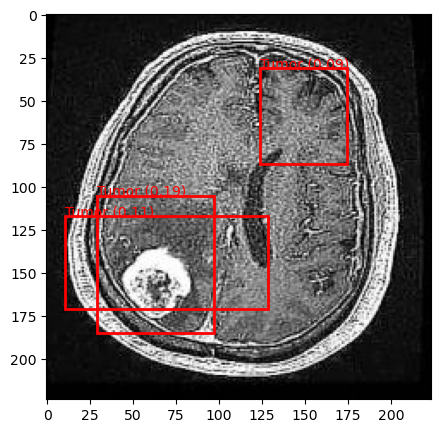

In [30]:
# Display the image with bounding boxes and correct labels

draw_boxes(
    Image.open(image_path), 
    prediction, 
    fig_size=(5, 5)
)